<a href="https://colab.research.google.com/github/AHamamd150/MLscan_group/blob/main/AL_Varitional_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Active Learning with Varitional autoencoder.
* The idea is to use the latent space of the VAE to recomve the collapse of the AL scanner. VAE latent space is sampled as $\mu + exp^{(0.5 \sigma)}\times\epsilon$. with $\mu,\sigma$ are the mean and the standard deviation  values of the feature space. $\epsilon$ is the parameter we want to use to perturbate the latent space and generate more points little away from the boundries. 

# difficulties:
* VAE has  lots of hyperparameters to be tunned in each process.
* VAE perofrmance depends on the latent space diminsions.
* It is time consuming.

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential
# from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model,Sequential,layers
from tensorflow.keras.layers import Flatten,Dense,Dropout
import os
import keras
from keras.losses import mse,CategoricalCrossentropy,binary_crossentropy
from keras import backend as K
from tqdm import tqdm
import tensorflow as tf
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingRegressor,GradientBoostingClassifier,RandomForestClassifier
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import warnings
import sys
mirrored_strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1"])
## check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found.....')
    #sys.exit()
else:
    print('Default GPU device :{}'.format(tf.test.gpu_device_name()))
    
################

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: No GPU found.....


In [8]:
def obs(x1,x2):
    #F = (2+np.cos(x1)*np.cos(x2))**5
    F = (3*x1)**2+x2**2+7
    return np.array(F)  
def generate_init(n):
    x1,x2=[],[]
    for q in range(n):
        x1.append(np.random.uniform(-10,10))
        x2.append(np.random.uniform(-10,10))
    return np.array(x1),np.array(x2),np.array([x1,x2]).T

def orcal(x1,x2):
    #F = (2+np.cos(x1)*np.cos(x2))**5
    F = (3*x1)**2+x2**2+7
    for q,item in enumerate(F):
      if (item < 60 ):
        F[q] = 1
      else:
        F[q] =0   
    return np.array(F)  

score = lambda x : np.array([q*(1-q) for q in x])

In [9]:
epsilon = 0.01
def sampling(args):

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    #epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp( z_log_var) * epsilon

def encoder():
    encoder1 = Dense(100,activation='relu') (encoder_input)
    #encoder2 = Dense(70,activation='relu') (encoder1)
    encoder3 = Dense(50,activation='relu') (encoder1)
   # encoder4 = Dense(20,activation='relu') (encoder3)
    encoder5 = Dense(10,activation='relu') (encoder3)
    #encoder_output = layers.Dense(decoder_inputdim,activation='relu')(encoder1)
    z_mean = layers.Dense(latent, name='z_mean')(encoder5)
    z_log_var = layers.Dense(latent, name='z_log_var')(encoder5)
    z = layers.Lambda(sampling, output_shape=(latent,), name='z')([z_mean, z_log_var])
    encoder_model = Model(encoder_input, [z_mean, z_log_var, z])
    return encoder_model, z_mean, z_log_var



# define the decoder
def decoder():
    decoder_input = keras.Input(shape=(latent,))
    decoder1 = Dense(10,activation='relu') (decoder_input)
    #decoder2 = Dense(20,activation='relu') (decoder1)
    decoder3 = Dense(50,activation='relu') (decoder1)
    #decoder4 = Dense(70,activation='relu') (decoder3)
    decoder5 = Dense(100,activation='relu') (decoder3)
    decoder_output = layers.Dense(2,activation=None)(decoder5)
    decoder_model= Model(decoder_input,decoder_output)
    return decoder_model


latent=2  # Dimensions of the latent space
decoder_inputdim=10 
encoder_input = keras.Input(shape=(2,)) 

encoder_model, z_mean, z_log_var = encoder() 
decoder_model = decoder() 
encoder_model.summary(),decoder_model.summary();    
outputs = decoder_model(encoder_model(encoder_input)[2]) # 2 to return the z parameter
VAE = Model(encoder_input,outputs,name='VAE') 
# define the custom loss function as : reconstruction loss function + KL divergence loss function
def Loss(inputs,output):
    inputs = K.flatten(inputs)
    output= K.flatten(outputs)
    reconstruction_loss = mse(inputs, output)
    reconstruction_loss *= decoder_inputdim
    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    VAE_loss =K.mean(reconstruction_loss + kl_loss)
    return VAE_loss

VAE.add_loss(Loss(encoder_input,outputs))
VAE.compile(optimizer='adam',loss=None)

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 2)]          0           []                               
                                                                                                  
 dense_14 (Dense)               (None, 100)          300         ['input_5[0][0]']                
                                                                                                  
 dense_15 (Dense)               (None, 50)           5050        ['dense_14[0][0]']               
                                                                                                  
 dense_16 (Dense)               (None, 10)           510         ['dense_15[0][0]']               
                                                                                            

Progress: 100%|##########| 50/50 [04:11<00:00,  5.03s/it]


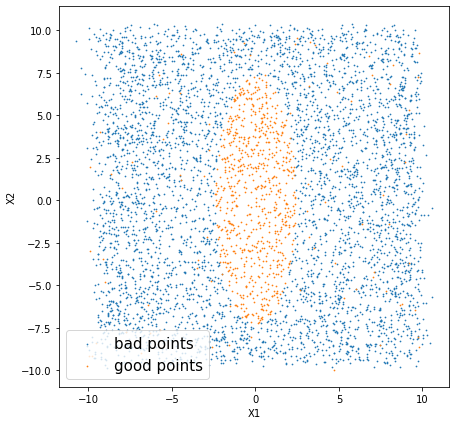

In [10]:
def run_AL(runs =20,learning_rate=0.01,n_estimators=100,max_depth=30,print_output=True):
    BDT =GradientBoostingClassifier(learning_rate=learning_rate,n_estimators=n_estimators,max_depth=max_depth)
    x1,x2,X=generate_init(100)
    obs1 = orcal(x1, x2)
    BDT.fit(X, obs1)         
    badP1,badP2 =[],[]
    for q in tqdm(range(runs),ascii=True,desc='Progress'): 
      X1,X24,x = generate_init(1000)
      pred = BDT.predict(x).flatten()
      X_new = x[pred==1][:90]
      q = np.argsort(score(pred))[::-1]
      q_new = x#[q[:10]]
      X_new = np.append(X_new,q_new[:10],axis=0)
      VAE.fit(X_new,epochs=500,verbose=0)
      _,_,x_test=generate_init(100)
      z_mean, _, _ = encoder_model.predict(x_test)
      x_new= decoder_model.predict(z_mean)
      ob = orcal(x_new[:,0], x_new[:,1])
      Y = ob == 1
      badP1.append(x_new[ob!=1][:,0])  
      badP2.append(x_new[ob!=1][:,1])
      X= np.append(X,x_new[Y],axis=0)
      obs1=np.append(obs1,ob[Y],axis=0)
      BDT.fit(X, obs1) 
    return X,badP1,badP2
Flatten = lambda x : [item for i in x for item in i]    
XL,dd1,dd2 = run_AL(runs=50)
plt.figure(figsize=(7,7))
plt.scatter(Flatten(dd1),Flatten(dd2),s=0.5,label = 'bad points')
plt.scatter(XL[:,0],XL[:,1],s=0.5,label='good points');

plt.xlabel('X1')
plt.ylabel('X2')
plt.legend(fontsize=15)
#plt.title('Active Learning- Sampled batch (points= {:0.0f})'.format(len(XL)))
plt.show()